In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon, Patch

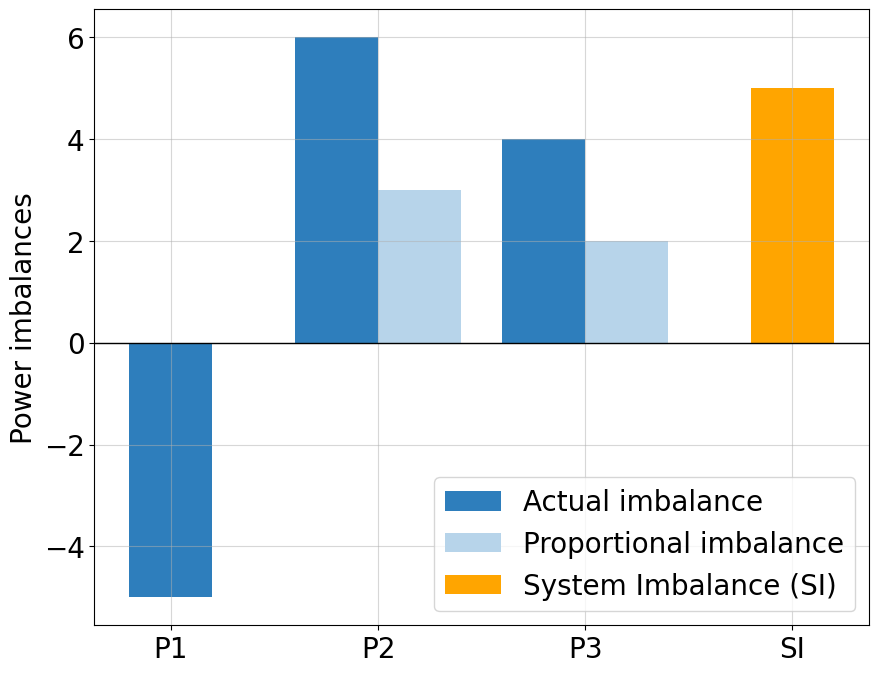

In [4]:

# Data for the plot
labels = ["P1", "P2", "P3", "SI"]
x = np.arange(len(labels))

# Values
helpers = [-5, 0, 0, 0]                  # light blue (helps system)
individual = [0, 6, 4, 0]               # darker blue
system_imb = [0, 0, 0, helpers[0] + individual[1] + individual[2]]               # yellow bar
prop1 = individual[1]/(individual[1] + individual[2])*system_imb[3]
prop2 = individual[2]/(individual[1] + individual[2])*system_imb[3]
proportional = [0, prop1, prop2, 0]             # lighter blue

# Width for grouped bars
width = 0.4

fig, ax = plt.subplots(figsize=(10,8))

# Bars
ax.bar(x[0], helpers[0], width, label="Actual imbalance", color=plt.cm.Blues(0.7))
ax.bar(x[1] - width/2, individual[1], width, color=plt.cm.Blues(0.7))
ax.bar(x[1] + width/2, proportional[1], width, label="Proportional imbalance", color=plt.cm.Blues(0.3))

ax.bar(x[2] - width/2, individual[2], width, color=plt.cm.Blues(0.7))
ax.bar(x[2] + width/2, proportional[2], width, color=plt.cm.Blues(0.3))

ax.bar(x[3], system_imb[3], width, color='orange', label="System Imbalance (SI)")

# Decorations
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(0, color="black", linewidth=1)
ax.set_ylabel("Power imbalances")
#ax.set_title("Power imbalances and contribution")
ax.legend(loc = 'lower right')
ax.grid(True, alpha=0.5)

plt.rcParams.update({
    "font.size": 20,       # base font size
    "axes.titlesize": 20,  # title
    "axes.labelsize": 20,  # x/y labels
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

#plt.tight_layout()
plt.savefig("../Figures/Intro/imbalance_plot.pdf", bbox_inches="tight")
plt.show()


In [5]:
nF = 8

rf_up = [40, 55, 60, 45, 50, 35, 55, 50]
rf_down = [15, 20, 25, 10, 20, 35, 30, 25]

Cf_Rup = [8.0, 6.0, 4.0, 5.0, 7.0, 5.0, 5.0, 6.0]
Cf_Rdown = [2.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 2.0]

RI_up = 300 # MW
RI_down = 0 # MW

NI_up = 80.0       # MW
NI_down = 160.0     # MW 

q_up = 5400
q_down = 700

bids_up = [(rf_up[i], Cf_Rup[i], "F$(i)") for i in range(nF)]
sorted_bids_up = sorted(bids_up, key=lambda x: x[1])

bids_down = [(rf_down[i], Cf_Rdown[i], "F$(i)") for i in range(nF)]
sorted_bids_down = sorted(bids_down, key=lambda x: x[1])

lambda_RI_up, lambda_RI_down = 6.0, 1.0
lambda_RI_NI_up, lambda_RI_NI_down = 6.0, 3.0

q_up, q_down = (1800.0, 480.0)

In [6]:
def price_at(x, y, q):
    """Return price y[i] at quantity q, with price(0) = 0 by definition."""
    x = np.asarray(x)
    y = np.asarray(y)

    if q == 0:
        return 0.0   # enforce your desired rule

    assert x[0] <= q <= x[-1], "q outside curve range"

    idx = np.where(x <= q)[0][-1]
    return y[idx]

def plot_RI_RINI_transparent(rf, cost, RI, NI, title="Reserve market", sign="up"):
    rf = np.asarray(rf)
    cost = np.asarray(cost)

    # Arrow direction
    if sign.lower() == "up":
        arrow = "↑" 
    elif sign.lower() == "down":
        arrow = "↓" 
    else:
        arrow = " "

    # Sort by cost
    bids = sorted(zip(rf, cost), key=lambda x: x[1])

    x = [0.0]
    y = [0.0]

    for mw, cst in bids:
        x.append(x[-1])
        y.append(cst)
        x.append(x[-1] + mw)
        y.append(cst)

    d_RI = float(RI)
    d_RINI = float(RI + NI)

    λ_RI = price_at(x, y, d_RI)
    λ_RINI = price_at(x, y, d_RINI)

    xmax = max(x[-1], d_RINI) * 1.05
    ymax = max(max(cost), λ_RI, λ_RINI) * 1.15

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_xlabel("Reserve Capacity (MW)")
    ax.set_ylabel("Reserve Cost (€/MW)")
    ax.set_title(title)

    # Transparent background
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    # ---- XTICKS with numeric values ----
    #ax.set_xticks([0.0, d_RI-0.02*d_RI, d_RINI-0.02*d_RINI])
    ax.set_xticks([0.0, d_RI, d_RINI])

    ax.set_xticklabels([
        "0",
        rf"$RI$",
        rf"$RI+NI$"
    ])

    # Shaded areas
    shade = plt.cm.Blues(0.3)
    poly1 = Polygon([[0, λ_RI], [d_RI, λ_RI], [d_RI, λ_RINI], [0, λ_RINI]],
                    closed=True, facecolor=shade, alpha=0.7, edgecolor="none")
    ax.add_patch(poly1)

    poly2 = Polygon([[d_RI, 0], [d_RINI, 0], [d_RINI, λ_RINI], [d_RI, λ_RINI]],
                    closed=True, facecolor=shade, alpha=0.7, edgecolor="none")
    ax.add_patch(poly2)

    # Dashed guides
    ax.axvline(d_RI, linestyle="--", linewidth=2, color="gray")
    ax.axvline(d_RINI, linestyle="--", linewidth=2, color="gray")
    ax.axhline(λ_RI, linestyle="--", linewidth=2, color="gray")
    ax.axhline(λ_RINI, linestyle="--", linewidth=2, color="gray")

    # Vertical offset
    off = 0.035 * ymax

    # Lambda labels using arrow
    ax.text(xmax * 0.02, λ_RI + off, rf"$\lambda_{{RI}}$", ha="left")
    ax.text(xmax * 0.02, λ_RINI + off, rf"$\lambda_{{RI+NI}}$", ha="left")

    # Step curve
    ax.plot(x, y, linewidth=3, color=plt.cm.Blues(0.7))
    ax.scatter([d_RI, d_RINI], [λ_RI, λ_RINI], s=50, color=plt.cm.Blues(0.7))

    # Center Q
    xmid = 0.5 * (d_RI + d_RINI)
    ymid = 0.5 * (λ_RI + λ_RINI)

#    ax.text(xmid, ymid, rf"$Q^{arrow}$", fontsize=22, ha="center", va="center", color = plt.cm.Blues(0.7))
    offset = 0.07 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # 5% below curve

    ax.text(
        xmid,
        ymid - offset,
        rf"$Q^{arrow}$",
        fontsize=18,
        ha="center",
        va="top",
        color=plt.cm.Blues(0.7)
    )

    # ---- Legend below the plot ----
    shade_patch = Patch(facecolor=shade, label=rf"Procurement cost $Q^{arrow}$", edgecolor="none")
    ax.legend(handles=[shade_patch], loc="lower right")

    plt.rcParams.update({
    "font.size": 18,       # base font size
    "axes.titlesize": 18,  # title
    "axes.labelsize": 18,  # x/y labels
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
    })

    return fig, λ_RI, λ_RINI


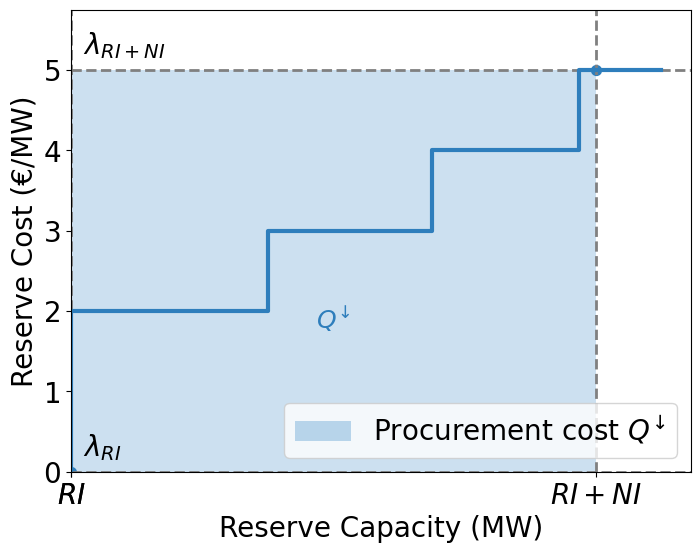

In [ ]:
plot_RI_RINI_transparent(rf_down, Cf_Rdown, RI_down, NI_down, title="", sign = "down")
plt.savefig("../Figures/Intro/Q_down.pdf", bbox_inches="tight")


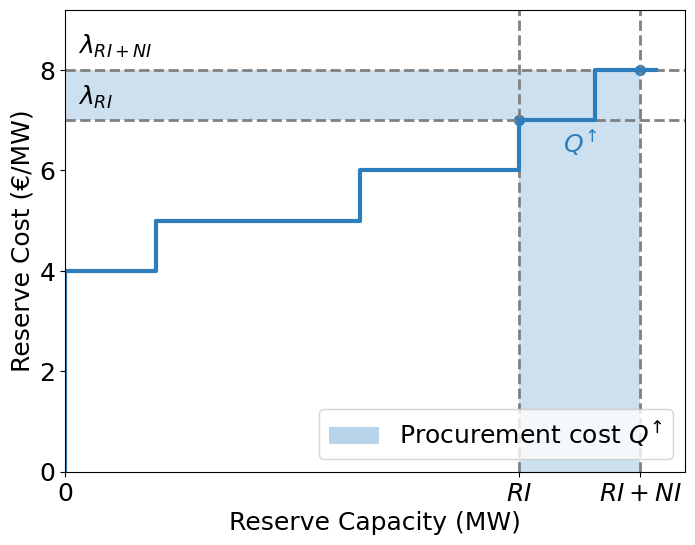

In [ ]:
plot_RI_RINI_transparent(rf_up, Cf_Rup, RI_up, NI_up, title="", sign = "up")
plt.savefig("../Figures/Intro/Q_up.pdf", bbox_inches="tight")


(<Figure size 800x600 with 1 Axes>, np.float64(7.0), np.float64(8.0))

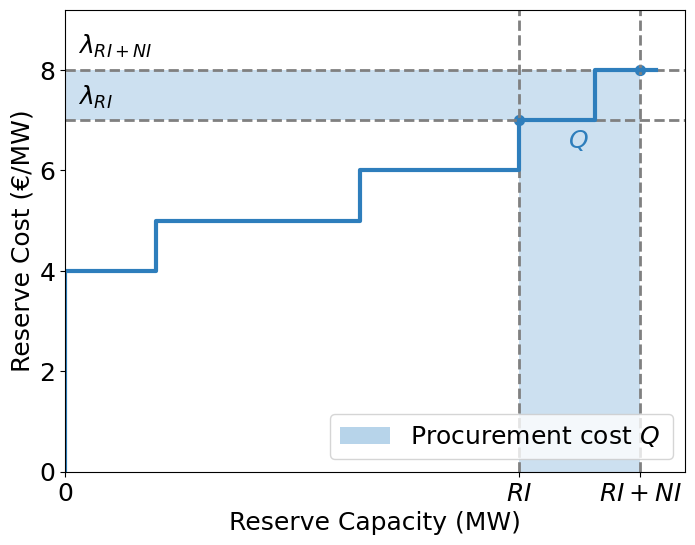

In [9]:
plot_RI_RINI_transparent(rf_up, Cf_Rup, RI_up, NI_up, title="", sign = "0")
#plt.savefig("../Figures/Q_gen.pdf", bbox_inches="tight")
